In [5]:
%pip install -e ../introdl

Obtaining file:///Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff%40gmail.com/My%20Drive/Python_Projects/DS776_Develop_Project/DS776/introdl
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for introdl (pyproject.toml) ... done
  Created wheel for introdl: filename=introdl-1.0-0.editable-py3-none-any.whl size=1370 sha256=598765d403c087747ff7ddca38e8c0f8657dfad18db8bf336470526104d96e2a
  Stored in directory: /private/var/folders/8w/0_6f1mnj291b3dfy5xqyp1rd3h18sr/T/pip-ephem-wheel-cache-gxx1k7wq/wheels/5b/bf/70/55a8428f6f3d659e30893470f0f3288d50ebdacbeb3fda3f35
Successfully built introdl
    torch (>=1.9.*)
           ~~~~~~^
  Attempting uninstall: introdl
    Found existing installation: introdl 1.0
    Uninstalling introdl-1.0:
      Successfully uninstalled introdl-1.0
Note: you may need to rest

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from introdl.utils import get_device, load_results, load_model
from introdl.idlmam import train_network
from introdl.visul import plot_training_metrics
import numpy as np
import seaborn as sns

from sklearn.metrics import accuracy_score

# Data Augmentation for training our CIFAR-10 Classifiers

In this notebook we'll apply data augmentation to our training pipeline ...

First we'll setup our model and dataloaders as we did previously.

## Setup

We simply copied the model and data loaders function from our previous notebook.

In [1]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()

def create_CIFAR10_loaders(transform_train, transform_test, valid_prop=0.2, batch_size=64, seed=42):
    """
    Create data loaders for the CIFAR10 dataset.

    Args:
        transform_train (torchvision.transforms.Compose): A composition of transformations to apply to the training dataset.
        transform_test (torchvision.transforms.Compose): A composition of transformations to apply to the test dataset.
        valid_prop (float): The proportion of the training dataset to use for validation.
        seed (int, optional): Random seed for reproducibility. Defaults to 42.

    Returns:
        torch.utils.data.DataLoader: A data loader for the training dataset.
        torch.utils.data.DataLoader: A data loader for the validation dataset.
        torch.utils.data.DataLoader: A data loader for the test dataset.
    """

    # Set random seed for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    # Load the full dataset
    train_dataset_full = CIFAR10(root='../data', train=True, download=True, transform=transform_train)
    test_dataset = CIFAR10(root='../data', train=False, download=True, transform=transform_test)

    # Split the dataset into training and validation sets
    train_size = int((1 - valid_prop) * len(train_dataset_full))
    valid_size = len(train_dataset_full) - train_size
    train_dataset, valid_dataset = random_split(train_dataset_full, [train_size, valid_size])

    # Create data loaders (may want more workers on CUDA or CPU, but only 1 on MPS)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

    return train_loader, valid_loader, test_loader

NameError: name 'nn' is not defined

Here is the plot of the training metrics when we used `AdamW` with `lr=0.001` and `weight_decay=0.5`.  

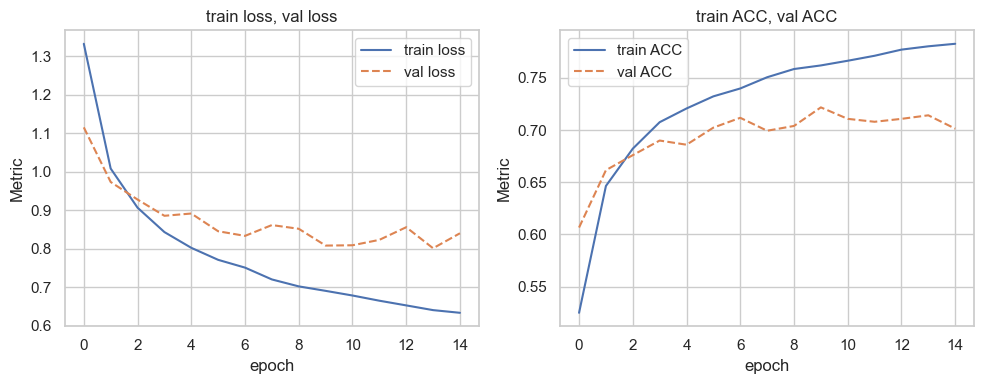

In [15]:
ckpt_file = 'models/model_CIFAR10_AdamW_wd.pt'
results = load_results(ckpt_file)

plot_training_metrics(results, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

While we're getting about 70% accuracy on the validation set, but we're seeing evidence of fairly strong overfitting.  As we'll see below, using data augmentation can both increase the model performance and decrease the overfitting.

## Data Augmentation

Deep learning models are data-hungry, and one way to increase the amount of data available for training is to augment the data. Data augmentation is a technique used to increase the diversity of the training data by applying random transformations to the input data. This can help the model generalize better to unseen data and reduce overfitting.

In this Jupyter Notebook, PyTorch is used to include random transforms in the list of transforms that are passed to the Dataset, which prepares the data for the model. Two common random transforms used for data augmentation are random horizontal flips and random cropping.

The random horizontal flip transform randomly flips the input image horizontally with a probability of 0.5. This means that for each image, there is a 50% chance that it will be flipped horizontally. This transformation helps to increase the diversity of the training data by providing different perspectives of the same object. By randomly flipping the images, the model learns to recognize objects regardless of their orientation, which improves its ability to generalize to unseen data.

The random cropping transform randomly selects a portion of the input image and crops it to a specified size. This helps to simulate the effect of having different viewpoints or zoom levels of the same object in the training data. The role of padding in the random crop transform is to ensure that the cropped portion of the image is still valid and does not exceed the boundaries of the original image. Padding adds extra pixels around the image to create a larger canvas for the crop, ensuring that the cropped portion is centered and does not go beyond the image boundaries.

Random cropping also helps to increase translation invariance in the model. Translation invariance refers to the ability of the model to recognize objects regardless of their position in the image. By randomly cropping the images, the model learns to focus on different parts of the object, which improves its ability to recognize the object even if it appears in different positions within the image.

By applying these random transformations to the training data, the model is exposed to a wider range of variations in the input data. This helps to prevent overfitting by forcing the model to learn more general features that are applicable to different variations of the same object. As a result, the model becomes more robust and better able to generalize to unseen data.

Files already downloaded and verified


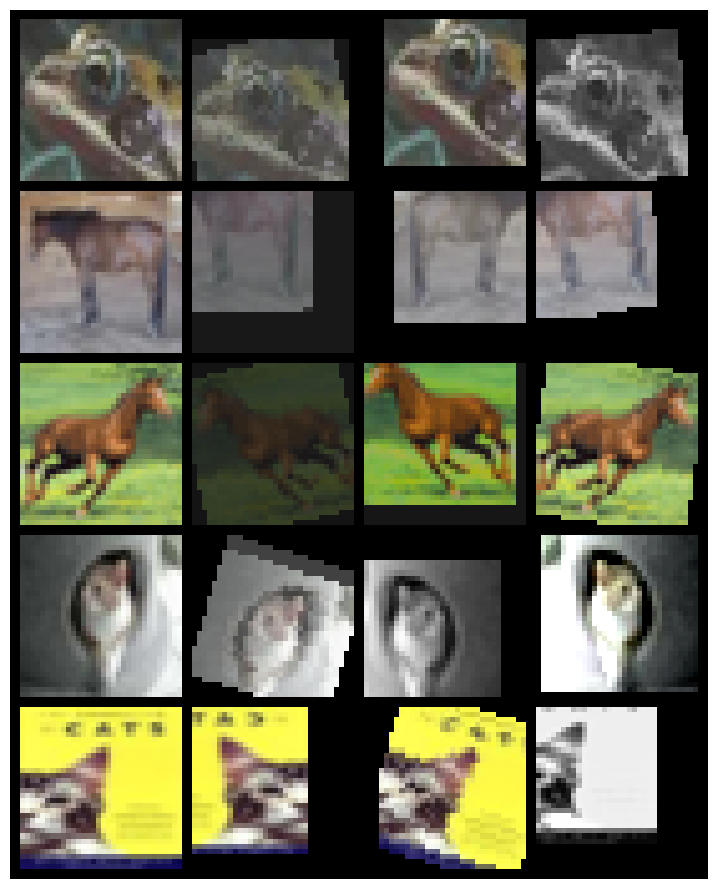

In [17]:
import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import random

def show_random_transformed_images(dataset, m=4, n=4, transform_list=None, num_transforms=1):
    """
    Show a grid of images where each row consists of an original image and its n random transforms.

    Args:
        dataset: PyTorch dataset of images (e.g., CIFAR10).
        m: Number of images to randomly choose from the dataset.
        n: Number of random transforms to apply to each chosen image.
        transform_list: List of transforms to choose from.
        num_transforms: Number of transforms to apply sequentially to each image.
    """
    if transform_list is None:
        transform_list = [
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomCrop(size=32, padding=4)
        ]
    
    # Cap num_transforms at the number of available transforms
    num_transforms = min(num_transforms, len(transform_list))
    
    # Select m random indices from the dataset
    indices = random.sample(range(len(dataset)), m)
    rows = []

    for idx in indices:
        # Get the original image and convert it to a tensor (assuming PIL image in dataset)
        original_image, _ = dataset[idx]
        if not isinstance(original_image, torch.Tensor):
            original_image = transforms.ToTensor()(original_image)
        
        # Collect n transformed versions of the original image
        transformed_images = [original_image]
        for _ in range(n):
            transformed_image = original_image
            for _ in range(num_transforms):
                transform = random.choice(transform_list)
                transformed_image = transform(transformed_image)
            transformed_images.append(transformed_image)
        
        # Stack the original and transformed images horizontally
        rows.append(torch.stack(transformed_images))

    # Make a grid with m rows
    grid = vutils.make_grid(torch.cat(rows, dim=0), nrow=n+1, padding=2, normalize=True)
    
    # Plot the grid
    plt.figure(figsize=(n * 3, m * 3))
    plt.axis('off')
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()


import torchvision.datasets as datasets
cifar10 = datasets.CIFAR10(root='../data', train=True, download=True)
show_random_transformed_images(cifar10, m=5, n=3, num_transforms=5)

When choosing transforms for data augmentation, the goal is to increase the diversity of the training data while preserving the integrity of the original images. Here are some general guidelines to consider:

1. **Random Flips**: Randomly flipping images horizontally or vertically can help the model learn to recognize objects from different perspectives. This is particularly useful for tasks where object orientation is not important.

2. **Random Rotations**: Applying random rotations to the images can help the model become more robust to variations in object orientation. However, be cautious with large rotation angles, as they may introduce unrealistic distortions.

3. **Color Jittering**: Randomly adjusting the brightness, contrast, saturation, and hue of the images can introduce variations in lighting conditions. This can help the model generalize better to different lighting conditions in real-world scenarios.

4. **Random Grayscale**: Converting images to grayscale randomly can help the model focus on texture and shape rather than color. This can be useful when color is not a significant factor in the task.

5. **Random Crop**: Randomly cropping a portion of the image can simulate different viewpoints or zoom levels of the same object. This helps the model become more translation-invariant and improves its ability to recognize objects in different positions within the image.

6. **Resize and Padding**: Resizing images to a specific size and adding padding can ensure that all images have the same dimensions. This is important when working with models that require fixed input sizes.

7. **Normalization**: Applying normalization to the images can help the model converge faster during training. Normalization typically involves subtracting the mean and dividing by the standard deviation of the image dataset.

Remember to strike a balance between introducing enough variations to improve generalization and avoiding excessive distortions that may hinder the model's ability to learn meaningful patterns. It's also important to consider the specific requirements of your task and the characteristics of your dataset when choosing transforms for data augmentation.

### Train our CNN with Data Augmentation

The random rotations above seemed to distort the images too much.  Let's try using RandomCrop, RandomHorizontalFlip, and milder ColorJitter for data augmentation with CIFAR10.  We'll also need our usual Normalize and ToTensor transforms.  Here's how we can create new datasets and loaders using the function we introduced earlier. Two things to note:

1. We don't want to use augmentation with the testing transforms.  (Though there is a technique called Test Time Augmentation in which the predictions are averaged over multiple transformations of each input image to get more robust predictions.)

2. We need to do the augmentation transformations BEFORE the the ToTensor transformation because transforms like RandomCrop expect image data, not PyTorch tensors.

In [18]:
# Mean and Std for CIFAR10 dataset
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)    
])

# Normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_loader, valid_loader, test_loader = create_CIFAR10_loaders(transform_train, transform_test)

Files already downloaded and verified
Files already downloaded and verified


Initially we trained this model for 15 epochs, but since it was doing well we let it train for 30 epochs to see how well it could do.  

If you're experimenting with how long to train you can run for a few epochs, check your results, then run for more epochs.  There are two ways to resume training from a checkpoint file.  Both will run for however many *additional* epochs you specify.

1.  By adding `resume_checkpoint=True`.  If you do that, `train_network` will resume training from the specified checkpoint file and overwrite that file.
2.  If you don't want to overwrite your current checkpoint file, you can specify `resume_file={current checkpoint file}` and `checkpoint_file={next checkpoint file}`.  

In [30]:
# this cell took about 30 minutes on an M1 Macbook Pro - don't run it unless you need to retrain the model
model = SimpleCNN() # create a new instance of the model
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())  # default lr=0.001, weight_decay=0.01

device = get_device()
print(device)

ckpt_file = 'models/model_CIFAR10_AdamW_augment.pt'
epochs = 30

score_funcs = {'ACC':accuracy_score}

train_network(model,
    loss_func,
    train_loader,
    device=device,
    val_loader=valid_loader,
    epochs = epochs,
    optimizer = optimizer,
    score_funcs = {'ACC':accuracy_score},
    checkpoint_file = ckpt_file);

mps


Epoch: 100%|██████████| 30/30 [12:50<00:00, 25.67s/it]


In [1]:
ckpt_file = 'models/model_CIFAR10_AdamW_augment.pt'
AdamW_augment = load_results(ckpt_file)

plot_training_metrics(AdamW_augment, [['train loss', 'val loss'], ['train ACC', 'val ACC']])

NameError: name 'load_results' is not defined

We're continuing to overfit, but much less so than previously.  Note that we're using the default (small) value of weight_decay with AdamW so increasing that may help.  Let's plot the metrics using augmentation and the metrics from before when we trained with AdamW with weight_decay = 0.5

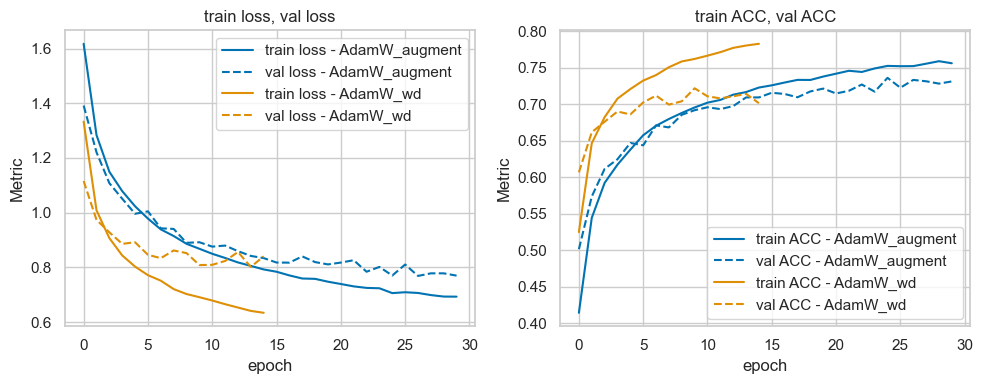

In [5]:
ckpt_file = 'models/model_CIFAR10_AdamW_augment.pt'
AdamW_augment = load_results(ckpt_file)

ckpt_file = 'models/model_CIFAR10_AdamW_wd.pt'
AdamW_wd = load_results(ckpt_file)

plot_training_metrics([AdamW_augment,AdamW_wd], 
                      [['train loss', 'val loss'], ['train ACC', 'val ACC']],
                      df_labels=['AdamW_augment', 'AdamW_wd'])

That picture is cluttered, but if you sort through the curves you can see that training with AdamW and data augmentation produces the least overfitting and the highest accuracy on the validation set.   

You could try increasing the weight decay parameter to see if you could reduce the overfitting further but the amount of weight decay will need to be carefully tuned.  If it's too large it will reduce performance and if it's too small it won't reduce overfitting much.  Usually a small value of weight decay, combined with data augmentation and improvements in the model architecture that we'll see in Lesson 4 is a better way to increase performance and further reduce overfitting.